In [ ]:
# import pandas as pd

In [ ]:
# df = pd.read_csv("/content/drive/MyDrive/BTC prices/BITCOIN_prices_2018_2025/btc_15m_data_2018_to_2025.csv")

In [ ]:
# df.columns

Index(['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Ignore'],
      dtype='object')

In [ ]:
df.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2018-01-01 00:00:00.000000,13715.65,13715.65,13400.01,13556.15,123.616013,2018-01-01 00:14:59.999000,1.675545e+06,1572,63.227133,8.576108e+05,0
1,2018-01-01 00:15:00.000000,13533.75,13550.87,13402.00,13521.12,98.136430,2018-01-01 00:29:59.999000,1.321757e+06,1461,47.686389,6.422812e+05,0
2,2018-01-01 00:30:00.000000,13500.00,13545.37,13450.00,13470.41,79.904037,2018-01-01 00:44:59.999000,1.078825e+06,1000,43.710406,5.900347e+05,0
3,2018-01-01 00:45:00.000000,13494.65,13690.87,13450.00,13529.01,141.699719,2018-01-01 00:59:59.999000,1.917783e+06,1195,73.897993,1.000614e+06,0
4,2018-01-01 01:00:00.000000,13528.99,13571.74,13402.28,13445.63,72.537533,2018-01-01 01:14:59.999000,9.778198e+05,898,34.257652,4.618369e+05,0


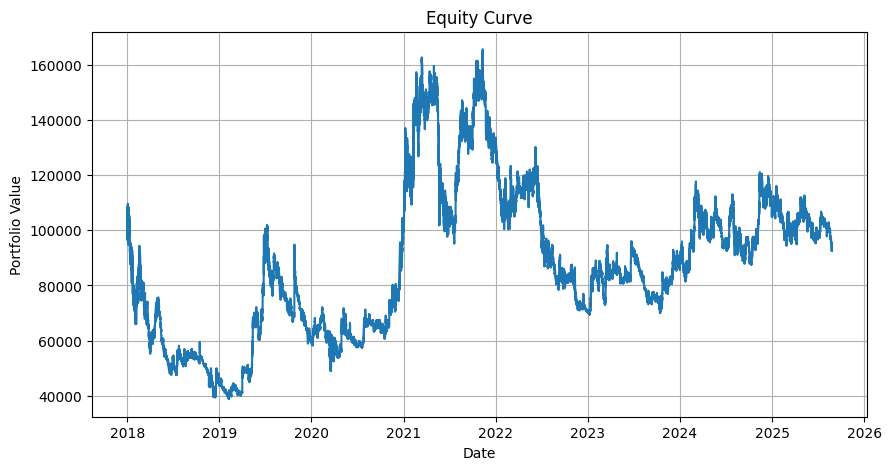

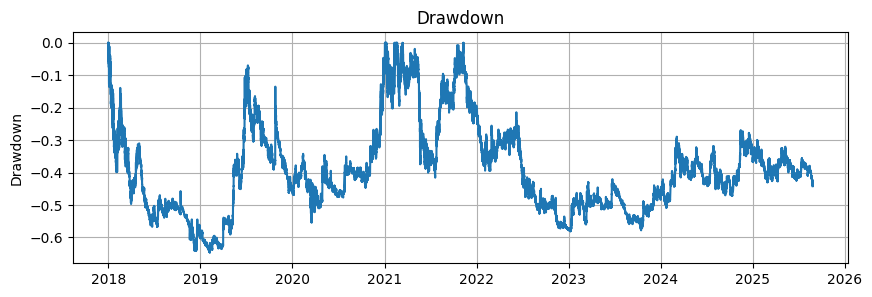

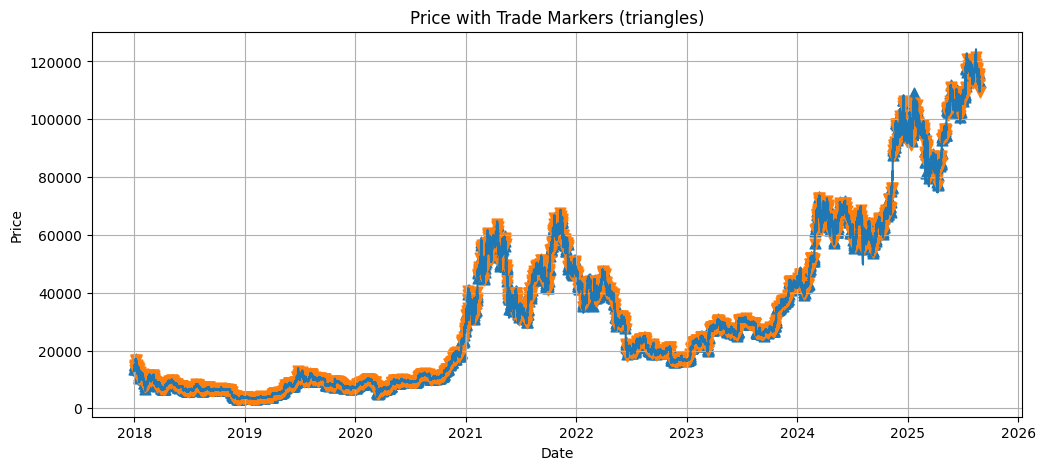

Performance metrics:
Total Return: -0.0749
CAGR: nan
Annualized Return: 0.1020
Annualized Vol: 0.4736
Sharpe: 0.2153
Max Drawdown: -0.6473
Max DD End: 2019-02-08 07:45:00
No of Trades : 6590
                     type        price    shares     cash_after
date                                                           
2018-01-01 21:30:00   BUY  13524.54103  7.393966      -1.000000
2018-01-02 05:45:00  SELL  13127.85900  7.393966   97064.946456
2018-01-02 11:15:00   BUY  13526.40289  7.175962      -1.000000
2018-01-03 10:45:00  SELL  14387.12847  7.175962  103239.480085
2018-01-03 17:15:00   BUY  14970.94599  6.895989      -1.000000

Files saved: equity_curve.csv and data/trades.csv


In [ ]:
# Minimal from-scratch backtesting engine demo
# This code will:
# - generate synthetic OHLCV data (geometric Brownian motion)
# - implement a simple backtester with Strategy, Portfolio, Broker
# - run an SMA crossover strategy
# - compute performance metrics and plot results
# - display a trade log table
#
# This is intentionally compact but clear and extensible.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

np.random.seed(42)

# 1) load the data
filename = "/content/drive/MyDrive/BTC prices/BITCOIN_prices_2018_2025/btc_15m_data_2018_to_2025.csv"

# Map for bars/year depending on timeframe
bars_per_year_map = {
    "1d": 252,
    "4h": 2190,
    "1h": 8760,
    "15m": 35040
}

# Infer timeframe from filename (lowercase for safety)
lower_name = filename.lower()
if "15m" in lower_name:
    bars_per_year = bars_per_year_map["15m"]
elif "1h" in lower_name and "15m" not in lower_name:  # avoid matching 15m
    bars_per_year = bars_per_year_map["1h"]
elif "4h" in lower_name:
    bars_per_year = bars_per_year_map["4h"]
elif "1d" in lower_name or "daily" in lower_name:
    bars_per_year = bars_per_year_map["1d"]
else:
    bars_per_year = 252  # default to daily if not found

# Load your dataset
data = pd.read_csv(filename)
# data = pd.read_csv("/content/drive/MyDrive/BTC prices/BITCOIN_prices_2018_2025/btc_15m_data_2018_to_2025.csv")

# Ensure datetime index
data['date'] = pd.to_datetime(data['Open time'])
data = data.set_index('date')



# Make sure columns are in the expected format
data = data[['Open','High','Low','Close','Volume']]

# Sort by date (important!)
data = data.sort_index()
data = data[~data.index.duplicated(keep='first')]


# 2) Simple indicator helpers
def sma(series, window):
    return series.rolling(window).mean()

# 3) Strategy interface and an SMA crossover implementation
class Strategy:
    def __init__(self, data):
        self.data = data
        self.signals = pd.Series(index=data.index, dtype='int')  # +1.0 long, 0.0 flat, -1.0 short ( only long )
    def generate_signals(self):
        raise NotImplementedError

class SMACrossover(Strategy):
    def __init__(self, data, short_window=20, long_window=50):
        super().__init__(data)
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self):
        close = self.data['Close']
        s = sma(close, self.short_window)
        l = sma(close, self.long_window)
        signal = pd.Series(0, index=close.index)
        # signal = 1 when short SMA crosses above long SMA, -1 when crosses below
        signal[(s > l) & (s.shift(1) <= l.shift(1))] = 1.0
        signal[(s < l) & (s.shift(1) >= l.shift(1))] = -1.0
        # convert to position: hold previous position until opposite signal
        position = 0
        positions = []
        for idx in signal.index:
            if signal.loc[idx] == 1.0:
                position = 1
            elif signal.loc[idx] == -1.0:
                position = 0  # we go to flat (no shorts in this simple example)
            positions.append(position)
        self.signals = pd.Series(positions, index=close.index)
        return self.signals

# 4) Simple Broker/Portfolio that executes at next open with slippage & commission
class Portfolio:
    def __init__(self, data, initial_cash=1000, commission_per_trade=1.0, slippage=0.0005):
        self.data = data
        self.cash = initial_cash
        self.initial_cash = initial_cash
        self.positions = 0.0  # number of shares long
        self.position_value = 0.0
        self.equity_curve = pd.Series(index=data.index, dtype='float')
        self.commission = commission_per_trade
        self.slippage = slippage
        self.trade_log = []

    def update_market_value(self, date):
        price = self.data.at[date, 'Close']
        self.position_value = self.positions * price
        self.equity_curve.at[date] = self.cash + self.position_value

    def execute_signal(self, date, signal):
        current_pos = self.positions
        desired_pos = signal
        price = self.data.at[date, 'Open']
        if current_pos == 0 and desired_pos == 1:
            # buy as much as risk allows
            available_cash = self.cash
            # apply slippage cost by adjusting executed price
            exec_price = price * (1 + self.slippage)
            shares = available_cash / exec_price
            if shares <= 0:
                return
            cost = shares * exec_price + self.commission
            self.cash -= cost
            self.positions += shares
            self.trade_log.append({'date': date, 'type': 'BUY', 'price': exec_price, 'shares': shares, 'cash_after': self.cash})
        elif current_pos > 0 and desired_pos == 0:
            # sell all
            exec_price = price * (1 - self.slippage)
            shares = self.positions
            proceeds = shares * exec_price - self.commission
            self.cash += proceeds
            self.positions = 0
            self.trade_log.append({'date': date, 'type': 'SELL', 'price': exec_price, 'shares': shares, 'cash_after': self.cash})
        # else: no change
        self.update_market_value(date)

# 5) Backtester orchestrator
class Backtester:
    def __init__(self, data, strategy, portfolio):
        self.data = data.copy()
        self.strategy = strategy
        self.portfolio = portfolio

    def run(self):
        signals = self.strategy.generate_signals()
        for date in self.data.index:
            sig = float(signals.loc[date]) if date in signals.index else 0.0
            self.portfolio.execute_signal(date, sig)
        # self.portfolio.execute_signal(date, sig)
            self.portfolio.update_market_value(date)
        # assemble results
        eq = self.portfolio.equity_curve.dropna()
        trades = pd.DataFrame(self.portfolio.trade_log)
        return eq, trades

# 6) Run a demo strategy
strategy = SMACrossover(data, short_window=20, long_window=50)
portfolio = Portfolio(data, initial_cash=100000, commission_per_trade=1.0, slippage=0.001)
bt = Backtester(data, strategy, portfolio)
equity_curve, trades = bt.run()

# 7) Performance metrics
def performance_metrics(equity_series, bars_per_year=252):
    returns = equity_series.pct_change().dropna()
    total_return = equity_series.iloc[-1] / equity_series.iloc[0] - 1
    days = (equity_series.index[-1] - equity_series.index[0]).days
    years = days / 365.25
    cagr = (equity_series.iloc[-1] / equity_series.iloc[0]) ** (1/years) - 1 if years > 0 else np.nan
    ann_ret = returns.mean() * bars_per_year
    ann_vol = returns.std() * sqrt(bars_per_year)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    running_max = equity_series.cummax()
    drawdown = equity_series / running_max - 1
    max_dd = drawdown.min()
    dd_end = drawdown.idxmin()
    return {
        'Total Return': total_return,
        'CAGR': cagr,
        'Annualized Return': ann_ret,
        'Annualized Vol': ann_vol,
        'Sharpe': sharpe,
        'Max Drawdown': max_dd,
        'Max DD End': dd_end
    }

# metrics = performance_metrics(equity_curve)
# set bars_per_year correctly depending on timeframe
# Daily → 252
# 4H → 2190
# 1H → 8760
# 15m → 35040
metrics = performance_metrics(equity_curve, bars_per_year=bars_per_year)

# 8) Plots: equity curve, drawdown, price with trades
plt.figure(figsize=(10,5))
plt.plot(equity_curve.index, equity_curve.values)
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

# Drawdown plot
running_max = equity_curve.cummax()
drawdown = equity_curve / running_max - 1
plt.figure(figsize=(10,3))
plt.plot(drawdown.index, drawdown.values)
plt.title('Drawdown')
plt.ylabel('Drawdown')
plt.grid(True)
plt.show()

# Price with trade markers
plt.figure(figsize=(12,5))
plt.plot(data.index, data['Close'])
buy_signals = trades[trades['type']=='BUY']
sell_signals = trades[trades['type']=='SELL']
if not buy_signals.empty:
    plt.scatter(buy_signals['date'], buy_signals['price'], marker='^', s=60)
if not sell_signals.empty:
    plt.scatter(sell_signals['date'], sell_signals['price'], marker='v', s=60)
plt.title('Price with Trade Markers (triangles)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# 9) Show key outputs
print("Performance metrics:")
for k,v in metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

if not trades.empty:
    trades_df = trades.copy()
    trades_df['date'] = pd.to_datetime(trades_df['date'])
    trades_df = trades_df.set_index('date')
    print(f"No of Trades : {len(trades_df)}")
    print(trades_df.head())
else:
    print("No trades were executed.")

import os

# your target directory
path = "./backtest_results"

# create it if it does not exist
os.makedirs(path, exist_ok=True)
# Save results CSV to /mnt/data for user download (if desired)
equity_curve.to_csv('./backtest_results/equity_curve.csv')
trades.to_csv('./backtest_results/trades.csv')
print("\nFiles saved: equity_curve.csv and data/trades.csv")


In [ ]:
# for 15 minutes data
# Performance metrics:
# Total Return: -0.0749
# CAGR: nan
# Annualized Return: 0.1020
# Annualized Vol: 0.4736
# Sharpe: 0.2153
# Max Drawdown: -0.6473
# Max DD End: 2019-02-08 07:45:00
# No of Trades : 6590

In [ ]:
# for 1 hour data
# Performance metrics:
# Total Return: 15.9052
# CAGR: nan
# Annualized Return: 1.8923
# Annualized Vol: 0.9085
# Sharpe: 2.0829
# Max Drawdown: -0.5134
# Max DD End: 2022-06-20 01:00:00
# No of Trades : 1608

In [ ]:
# for 4 hour data
# Performance metrics:
# Total Return: 16.9149
# CAGR: nan
# Annualized Return: 38.3480
# Annualized Vol: 22.7839
# Sharpe: 1.6831
# Max Drawdown: -0.9456
# Max DD End: 2019-02-14 08:00:00
# No of Trades : 380

In [ ]:
# for 1 day dataPerformance metrics:
# Total Return: 9.2006
# CAGR: 0.3547
# Annualized Return: 38.8530
# Annualized Vol: 4.4258
# Sharpe: 8.7788
# Max Drawdown: -0.5456
# Max DD End: 2019-03-04 00:00:00+00:00
# No of Trades : 61